# Working with Unknown Dataset Sizes

This notebook demonstrates the features built into OpenDP to handle unknown or private dataset sizes.

There are situations where simply the number of observations itself can leak private information.
For example, if a dataset contained all the individuals with a rare disease in a community,
then knowing the size of the dataset would reveal how many people in the community had that condition.
In general, any given dataset may be some well-defined subset of a population.
The given dataset's size is equivalent to a count query on that subset,
so we should protect the dataset size just as we would protect any other query we want to provide privacy guarantees for.

### Load exemplar dataset

In [1]:
# Define parameters up-front
# Each parameter is either a guess, a DP release, or public information
var_names = ["age", "sex", "educ", "race", "income", "married"]  # public information
age_bounds = (0., 120.) # an educated guess
age_prior = 38. # average age for entire US population (public information)
size = 1000 # records in dataset, public information

# Load data
import os
import numpy as np
data_path = os.path.join('..', 'data', 'PUMS_california_demographics_1000', 'data.csv')
age = np.genfromtxt(data_path, delimiter=',', names=var_names)[:]['age'].tolist()

## When dataset size is known

For contrast, we briefly start with the assumption that the dataset size is not protected.
If you know the dataset size (or any other parameter) is publicly available,
then you may make use of such information while building your measurement.

OpenDP treats any descriptors in the input domain as public information.
We incorporate the `size` descriptor into the input domain in the analysis below.

In [2]:
from opendp.transformations import *
from opendp.measurements import then_laplace
from opendp.mod import enable_features
from opendp.domains import vector_domain, atom_domain
from opendp.metrics import symmetric_distance

enable_features("contrib", "floating-point")

input_domain = vector_domain(atom_domain(T=float), size=1000)
input_metric = symmetric_distance()

dp_mean = (
    (input_domain, input_metric) >>
    # Clamp age values
    then_clamp(bounds=age_bounds) >>
    # Aggregate
    then_mean() >>
    # Noise
    then_laplace(scale=1.)
)

print("DP mean:", dp_mean(age))

DP mean: 48.41546783313125


In this case, OpenDP assumes that you truthfully and correctly know the size of the dataset.


### When dataset size is unkown
If you don't have a prior, ballpark estimate for `size`, you can first spend some of your privacy budget
to estimate the dataset size.
Here is an example:

In [3]:
# First, estimate the number of records in the dataset.
dp_count = (input_domain, input_metric) >> then_count() >> then_laplace(scale=1.)
dp_count_release = dp_count(age)
print("DP count: {0}".format(dp_count_release))

DP count: 999


If we want to conduct a bounded-DP analysis, we can establish the size descriptor via the "resize" transformation. 
The resize is a 2-stable dataset transformation, where you pass a fixed target size into the constructor.
If the true dataset has more records than the underlying dataset, it is sampled down,
and if the true dataset has fewer records than the underlying dataset, additional constant rows are imputed.

In [4]:
def make_mean_measurement(target_size):
    """a convenience constructor for building a mean measurement that resizes to `target_size`"""
    return ((vector_domain(atom_domain(T=float)), symmetric_distance()) >>
            then_resize(size=target_size, constant=age_prior) >>
            then_clamp(age_bounds) >>
            then_mean() >>
            then_laplace(scale=1.0))


dp_mean = make_mean_measurement(dp_count_release)
dp_mean_release = dp_mean(age)
print("DP mean: {0}".format(dp_mean_release))

DP mean: 45.518070978540095


### Providing incorrect dataset size values

The resize transformation does not assume you truthfully or correctly know the size of the dataset.
Moreover, it cannot respond with an error message if you get the size incorrect;
doing so would permit an attack whereby an analyst could repeatedly guess different dataset sizes until the error message went away,
thereby leaking the exact dataset size.

In this example, we intentionally provide under-estimates and over-estimates of `size` and still receive an answer.

In [5]:
lower_n = make_mean_measurement(target_size=200)(age)
real_n = make_mean_measurement(target_size=1000)(age)
higher_n = make_mean_measurement(target_size=2000)(age)

print("DP mean (n=200):  {0}".format(lower_n))
print("DP mean (n=1000): {0}".format(real_n))
print("DP mean (n=2000): {0}".format(higher_n))

DP mean (n=200):  42.81880656946988
DP mean (n=1000): 43.49853735856283
DP mean (n=2000): 40.50278188564646


There is an interesting trade-off to this approach, that can be demonstrated visually via simulations.
Before we move on to the visualizations, let's make a few helper functions for building measurements that consume a specified privacy budget.

In [6]:
from functools import lru_cache
from opendp.mod import binary_search_chain

input_space = vector_domain(atom_domain(T=float)), input_metric

@lru_cache(maxsize=None)
def make_count_with(*, epsilon):
    counter = input_space >> then_count()
    return binary_search_chain(
        lambda s: counter >> then_laplace(scale=s),
        d_in=1, d_out=epsilon, 
        bounds=(0., 10000.))

@lru_cache(maxsize=None)
def make_mean_with(*, target_size, epsilon):
    mean_chain = (
        input_space >>
        # Resize the dataset to length `target_size`.
        #     If there are fewer than `target_size` rows in the data, fill with a constant.
        #     If there are more than `target_size` rows in the data, only keep `data_size` rows
        then_resize(size=target_size, constant=age_prior) >>
        # Clamp age values
        then_clamp(bounds=age_bounds) >>
        # Compute the mean
        then_mean()
    )
    return binary_search_chain(
        lambda s: mean_chain >> then_laplace(scale=s),
        d_in=1, d_out=epsilon, 
        bounds=(0., 10.))

@lru_cache(maxsize=None)
def make_sum_with(*, epsilon):
    bounded_age_sum = (
        input_space >>
        # Clamp income values
        then_clamp(bounds=age_bounds) >>
        then_sum()
    )
    return binary_search_chain(
        lambda s: bounded_age_sum >> then_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 1000.))


In this simulation, we are running the same procedure `n_simulations` times. In each iteration, we collect the estimated count and mean.

In [7]:
n_simulations = 1000

history_count = []
history_mean = []

print("Status:")
for i in range(n_simulations):
    if i % 100 == 0:
        print(f"{i / n_simulations:.0%} ", end="")
    
    count_chain = make_count_with(epsilon=0.05)
    history_count.append(count_chain(age))
    
    mean_chain = make_mean_with(target_size=history_count[-1], epsilon=1.)
    history_mean.append(mean_chain(age))

print("100%")

Status:
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


Now we plot our simulation data, with counts on the X axis and means on the Y axis.

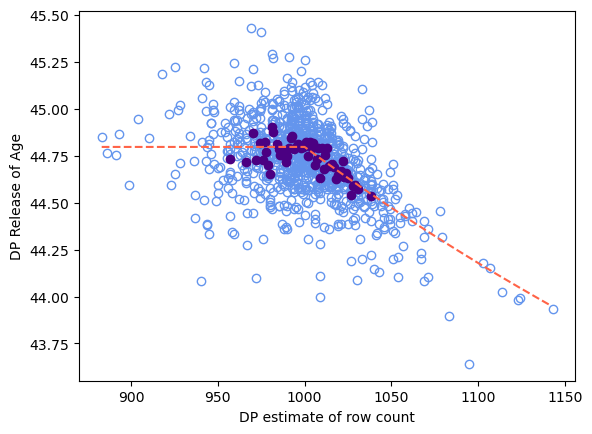

In [8]:
import matplotlib.pyplot as plt
import statistics

true_mean_age = statistics.mean(age)

# The light blue circles are DP means
plt.plot(history_count, history_mean, 'o', fillstyle='none', color = 'cornflowerblue')

def compute_expected_mean(count):
    count = max(count, size)
    return ((true_mean_age * size) + (count - size) * age_prior) / count

expected_count = list(range(min(history_count), max(history_count)))
expected_mean = list(map(compute_expected_mean, expected_count))

# The dark blue dots are the average DP mean per dataset size
for count in expected_count:
    sims = [m for c, m in zip(history_count, history_mean) if c == count]
    if len(sims) > 6:
        plt.plot(count, statistics.mean(sims), 'o', color = 'indigo')

# The red line is the expected value by dp release of dataset size
plt.plot(expected_count, expected_mean, linestyle='--', color = 'tomato')
plt.ylabel('DP Release of Age')
plt.xlabel('DP estimate of row count')
plt.show()

In this plot, the red dashed line is the expected outcome,
and each of the points represents a `(count, mean)` tuple from one iteration of the simulation.
Due to the behavior of the resize preprocess transformation,
underestimated counts lead to higher variance means,
and overestimated counts bias the mean closer to the imputation constant.
On the other hand, underestimated counts are unbiased, and overestimated counts have reduced variance.

Keep in mind that it is valid to postprocess the count to be smaller,
reducing the likelihood of introducing bias by imputing.
If the count is overestimated, the amount of bias introduced to the statistic
by imputation when resizing depends on how much the count estimate differs from the true dataset count,
and how much the imputation constant differs from the true dataset mean.
Since both of these quantities are private (and unknowable), they are not accounted for in accuracy estimates.

In the next plot, we see the range of DP means calculated as a function of the resized row count.
Note that the range of possible DP mean values decreases as the resized count increases, and that the DP mean gets
closer to the prior for the true value: 38.

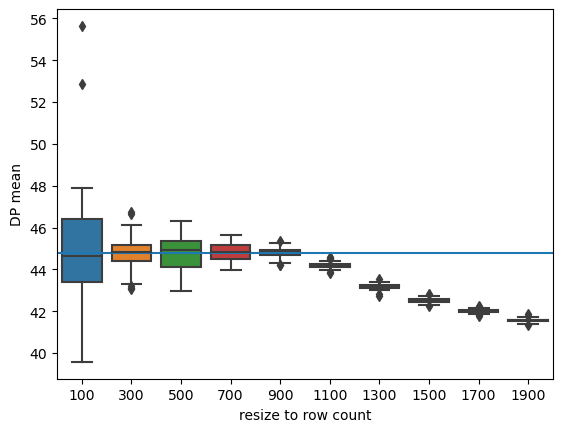

In [9]:
import pandas as pd
import seaborn as sns

releases = []
# X axis ticks
n_range = range(100, 2001, 200)
# Number of samples per boxplot
n_simulations = 50

for n in n_range:
    mean_chain = make_mean_with(target_size=n, epsilon=1.)
    for index in range(n_simulations):
        
        # get mean of age at the given n
        releases.append((n, mean_chain(age)))

# get released values
df = pd.DataFrame.from_records(releases, columns=['resize to row count', 'DP mean'])

# The boxplots show the distribution of releases per n
plot = sns.boxplot(x = 'resize to row count', y = 'DP mean', data = df)
# The blue line is the true mean
plot.axhline(true_mean_age)
plt.show()

The results from this approach have a similar interpretation as in the prior plot.
Underestimated counts lead to higher variance means,
and overestimated counts lead to greater bias in means.
Thankfully, the count is a low-sensitivity query, so count estimates are usually very close to the true count.

### OpenDP `resize` vs. other approaches
The standard formula for the mean of a variable is:
$\bar{x} = \frac{\sum{x}}{n}$

The conventional, and simpler, approach in the differential privacy literature, is to: 

1. compute a DP sum of the variable for the numerator
2. compute a DP count of the dataset rows for the denominator
3. take their ratio

This is sometimes called a 'plug-in' approach, as we are plugging-in differentially private answers for each of the
terms in the original formula, without any additional modifications, and using the resulting answer as our
estimate while ignoring the noise processes of differential privacy. While this 'plug-in' approach does result in a
differentially private value, the utility here is generally lower than the solution in OpenDP.  Because the number of
terms summed in the numerator does not agree with the value in the denominator, the variance is increased and the
resulting distribution becomes both biased and asymmetrical, which is visually noticeable in smaller samples.

In [10]:
n_simulations = 1_000
history_plugin = []
history_resize = []

# sized estimators are more robust to noisy counts, so epsilon is small
# the less epsilon provided to this count, the more the result will be biased towards the prior
resize_count = make_count_with(epsilon=0.2)

# plugin estimators want a much more accurate count
plugin_count = make_count_with(epsilon=0.5)
plugin_sum = make_sum_with(epsilon=0.5)

print("Status:")
for i in range(n_simulations):
    if i % 100 == 0:
        print(f"{i / n_simulations:.0%} ", end="")

    history_plugin.append(plugin_sum(age) / plugin_count(age))

    resize_mean = make_mean_with(target_size=resize_count(age), epsilon=.8)
    history_resize.append(resize_mean(age))
    
print('100%')

Status:
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


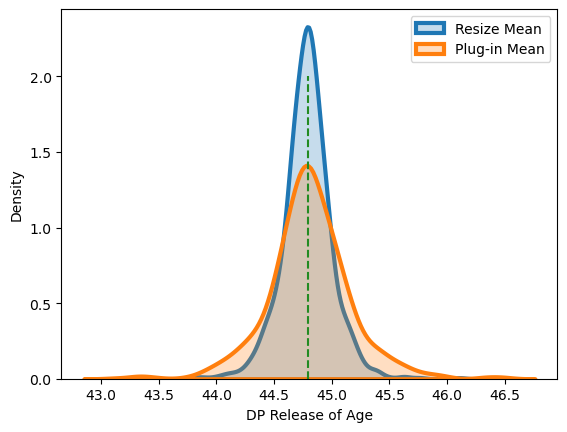

In [11]:
fig, ax = plt.subplots()
sns.kdeplot(history_resize, fill=True, linewidth=3,
                 label = 'Resize Mean')
sns.kdeplot(history_plugin, fill=True, linewidth=3,
                 label = 'Plug-in Mean')

ax.plot([true_mean_age,true_mean_age], [0,2], linestyle='--', color = 'forestgreen')
plt.xlabel('DP Release of Age')
leg = ax.legend()

We have noticed that for the same privacy loss,
the distribution of answers from OpenDP's resizing approach to the mean is tighter around the true dataset value (thus lower in error) than the conventional plug-in approach.

*Note, in these simulations, we've shown equal division of the epsilon for all constituent releases,
but higher utility (lower error) can be generally gained by moving more of the epsilon into the sum,
and using less in the count of the dataset rows, as in earlier examples.*